# **Resumen:** 
Vamos a hacer uso de de una dataset con personas que tienen insuficiencia cardiaca. Vamos a agrupar y usar patrones frecuentes para determinar que tipos de personas son máás propensas a sufrir de insuficiencia cardiaca.

# Descripción de los datos

- age: Edad del paciente (años)
- anaemia: disminución de los glóbulos rojos o de la hemoglobin (boleano) 0=false(no tiene);1=true(si tiene)
- high blood pressure: Si el paciente tiene hipertensión (boleano) 0=false(no tiene);1=true(si tiene)
- creatinine phosphokinase (CPK): nivel de la enzima CPK en la sangre (mcg/L)
- diabetes: Sí el paciente tiene diabetes (boleano) 0=false(no tiene); 1=true(si tiene)
- ejection fraction: porcentaje de sangre que sale del corazón en cada contracción (porcentaje)
- platelets: plaquetas en la sangre (kiloplaquetas/mL)
- sex: Mujer o Hombre (binario) mujer=0; hombre=1
- serum creatinine: nivel de creatinina sérica en la sangre (mg/dL)
- serum sodium: nivel de sodio sérico en la sangre (mEq/L)
- smoking: Si el paciente fuma o no (boleano) 0=false(no fuma); 1=true(si fuma)
- time: período de seguimiento (días)
- [target] death event: si el paciente falleció durante el período de seguimiento (boleano) 0 = sobrevivio; 1 = muerto

Para más información de los datos consultar: [dataset](https://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records#)

Paper de [Davide Chicco & Giuseppe Jurman](https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5) con una explicación más amplía

In [ ]:
#!pip install -U yellowbrick

Requirement already up-to-date: yellowbrick in /usr/local/lib/python3.6/dist-packages (1.2.1)


# **INDICE**
> [Procesamiento de datos](#procesamiento)

In [ ]:
#Cargamos las librerias que vamos a necesitar
import pandas as pd
import seaborn as sns

from yellowbrick.cluster import silhouette_visualizer
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

In [ ]:
# Cargamos los datos con los que vamos a trabajar
import pandas as pd
heart_failure = pd.read_csv('/content/heart_failure_clinical_records_dataset.csv')

In [ ]:
heart_failure.shape

(299, 13)

In [ ]:
heart_failure.head(5)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


<a id="procesamiento"><h1><strong>Procesamiento de datos</strong></h1></a>

* **Corroborar que no hay datos nulos**

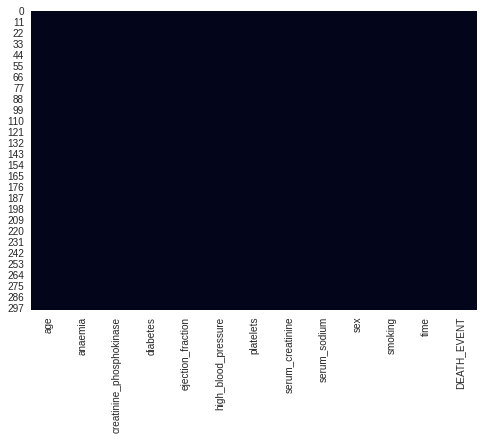

In [ ]:
# ESTADO DE LOS DATOS PARA EL INDICE GINI 
sns.heatmap(heart_failure.isnull(), cbar=False)

> **A partir del mapa de calor observamos que no hay datos faltantes**

* **Elección de columnas para trabajo**

In [ ]:
heart_failure.columns


Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

In [ ]:

##No creo que ocupemos la columna time
#Aunque en la matriz de correlacion vemos que time y death_event estan inversamente correlacionadas
#otra cosa, si estamos estudiando fallas de corazon, Que tanta importancia tiene la diabetes?
#En la matriz de correlacion, la diabetes esta muy poco correlacionada con Death event

#heart_failure.drop(['time'],axis=1,inplace=True)

In [ ]:
heart_failure['time']=heart_failure['time']*-1

In [ ]:
heart_failure['ejection_fraction']=heart_failure['ejection_fraction']*-1

In [ ]:
heart_failure

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,-20,1,265000.00,1.9,130,1,0,-4,1
1,55.0,0,7861,0,-38,0,263358.03,1.1,136,1,0,-6,1
2,65.0,0,146,0,-20,0,162000.00,1.3,129,1,1,-7,1
3,50.0,1,111,0,-20,0,210000.00,1.9,137,1,0,-7,1
4,65.0,1,160,1,-20,0,327000.00,2.7,116,0,0,-8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,-38,1,155000.00,1.1,143,1,1,-270,0
295,55.0,0,1820,0,-38,0,270000.00,1.2,139,0,0,-271,0
296,45.0,0,2060,1,-60,0,742000.00,0.8,138,0,0,-278,0
297,45.0,0,2413,0,-38,0,140000.00,1.4,140,1,1,-280,0


age          age                         1.000000
             anaemia                     0.088006
             creatinine_phosphokinase   -0.081584
             diabetes                   -0.101012
             ejection_fraction          -0.060098
                                           ...   
DEATH_EVENT  serum_sodium               -0.195204
             sex                        -0.004316
             smoking                    -0.012623
             time                        0.526964
             DEATH_EVENT                 1.000000
Length: 169, dtype: float64


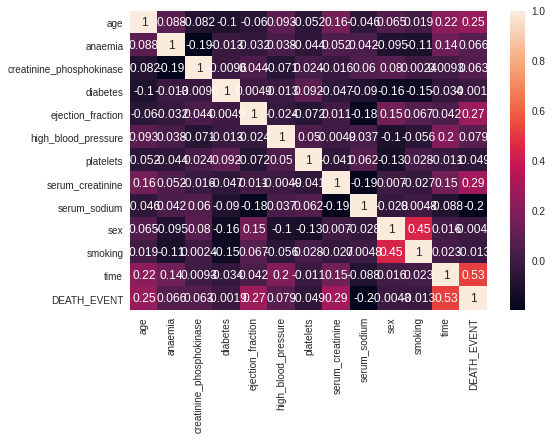

In [ ]:
correlation_mat = heart_failure.corr().unstack()

R=heart_failure.corr()

print(correlation_mat)
sns.heatmap(R, annot = True)


plt.show()


Para este proyecto, vamos a trabajar con todas las columnas, debido a que todas son importantes para determinar algun patrón en las personas con insuficiencia renal. Por lo tanto, no hay filtrado de datos.

- time
- death_evente
- sex 
- smoking
> Sacar de la tabla death event
- serum sodim 
- creatinine_phospokines

# **Clusterisación y patrones frecuentes**

- K-means
- Apriori

## **K-means y la elección efectiva de K**

In [ ]:
heart_failure.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

In [ ]:
eval = heart_failure[['age','ejection_fraction','serum_creatinine','time']]
eval.head()

,age,ejection_fraction,serum_creatinine,time
0,75.0,-20,1.9,-4
1,55.0,-38,1.1,-6
2,65.0,-20,1.3,-7
3,50.0,-20,1.9,-7
4,65.0,-20,2.7,-8


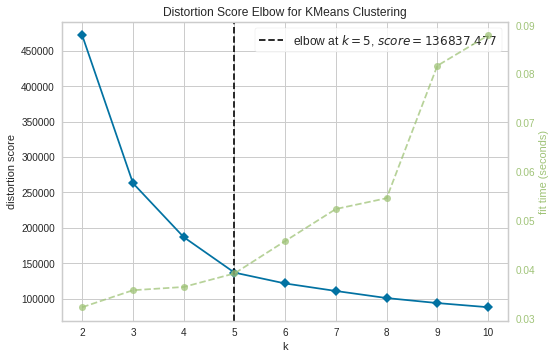

In [ ]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=10)
visualizer.fit(eval)
visualizer.show()

Para K= 3


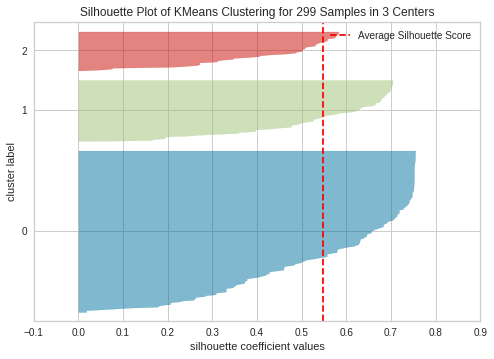

Para K= 4


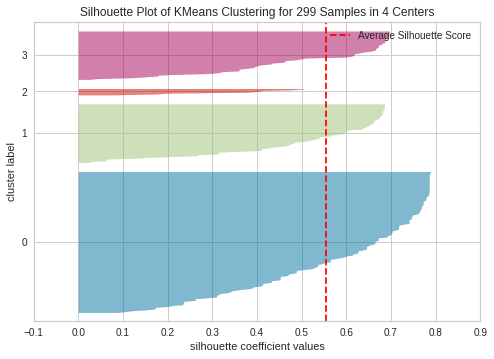

Para K= 5


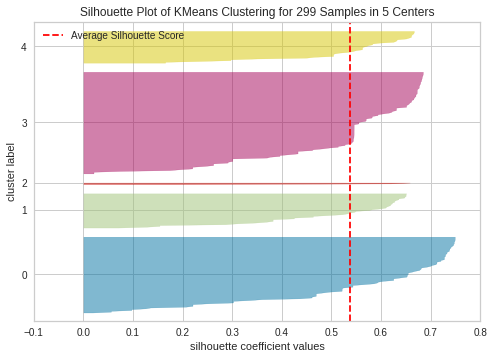

In [ ]:
for i in range(3,6):
  print("Para K=",i)
  silhouette_visualizer(KMeans(i), heart_failure, colors='yellowbrick')

A partir de las visualizaciones anteriores, tomamos **k=5**
cuya justificación en la primer gráfica consiste en que 5 es el número previo al 4 que es el punto en el que crece demasiado la inertia(Suma de distancias cuadradas de muestras a su centro de conglomerado más cercano.) hacia un lado pero hacía otro comienza a bajar. Y en el indice de silhouette, 5 forma 5 grupos que el algoritmo distingue perfectamente, por lo tanto. Tomamos **K=5**

## Formación de Clusters

In [ ]:
result = KMeans(n_clusters=5,init='random',max_iter=200).fit(eval)
result

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=200, n_clusters=5,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=None,
       tol=0.0001, verbose=0)

In [ ]:
result.labels_

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtyp

In [ ]:
cluster_result = list(result.labels_)
heart_failure = heart_failure.assign(Cluster_group = cluster_result)
heart_failure.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,Cluster_group
0,75.0,0,582,0,-20,1,265000.00,1.9,130,1,0,-4,1,4
1,55.0,0,7861,0,-38,0,263358.03,1.1,136,1,0,-6,1,4
2,65.0,0,146,0,-20,0,162000.00,1.3,129,1,1,-7,1,4
3,50.0,1,111,0,-20,0,210000.00,1.9,137,1,0,-7,1,4
4,65.0,1,160,1,-20,0,327000.00,2.7,116,0,0,-8,1,4


## Analisis de grupos

In [ ]:
cluster_1 = heart_failure[heart_failure['Cluster_group'] == 0]
cluster_1.mean()

age                             60.031541
anaemia                          0.405405
creatinine_phosphokinase       508.729730
diabetes                         0.378378
ejection_fraction              -37.702703
high_blood_pressure              0.378378
platelets                   265916.083108
serum_creatinine                 1.372568
serum_sodium                   136.270270
sex                              0.621622
smoking                          0.256757
time                          -196.932432
DEATH_EVENT                      0.162162
Cluster_group                    0.000000
dtype: float64

En el caso de las personas que pertenecen al **Cluster 1** observamos que en promedio, son las más propensas a morir durante los días de seguimiento. En su mayoría este grupo esta compuesto por hombres, en el que solo unos pocos fuman. 
Enfoquemonos en los siguientes datos: 
  * anaemia                          0.472727
  * creatinine_phosphokinase       472.109091
  * diabetes                         0.327273
  * ejection_fraction               36.509091
  * high_blood_pressure              0.309091
  * platelets                   142401.818182
  * serum_creatinine                 1.492364
  * serum_sodium                   136.890909

Para hacer la comparativa con los demás grupos. 

In [ ]:
cluster_2 = heart_failure[heart_failure['Cluster_group']==1]
cluster_2.mean()

age                             56.095238
anaemia                          0.285714
creatinine_phosphokinase       582.809524
diabetes                         0.547619
ejection_fraction              -38.380952
high_blood_pressure              0.095238
platelets                   264036.479048
serum_creatinine                 1.191190
serum_sodium                   137.285714
sex                              0.642857
smoking                          0.309524
time                          -249.190476
DEATH_EVENT                      0.047619
Cluster_group                    1.000000
dtype: float64

In [ ]:
cluster_3 = heart_failure[heart_failure['Cluster_group']==2]
cluster_3.mean()

age                             60.591549
anaemia                          0.422535
creatinine_phosphokinase       574.845070
diabetes                         0.380282
ejection_fraction              -38.802817
high_blood_pressure              0.380282
platelets                   272349.157042
serum_creatinine                 1.294789
serum_sodium                   137.126761
sex                              0.619718
smoking                          0.352113
time                           -79.619718
DEATH_EVENT                      0.309859
Cluster_group                    2.000000
dtype: float64

In [ ]:
cluster_4 = heart_failure[heart_failure['Cluster_group']==3]
cluster_4.mean()

age                             59.892857
anaemia                          0.464286
creatinine_phosphokinase       720.071429
diabetes                         0.357143
ejection_fraction              -39.303571
high_blood_pressure              0.321429
platelets                   248317.681250
serum_creatinine                 1.233036
serum_sodium                   137.267857
sex                              0.732143
smoking                          0.410714
time                          -123.357143
DEATH_EVENT                      0.178571
Cluster_group                    3.000000
dtype: float64

In [ ]:
cluster_5 = heart_failure[heart_failure['Cluster_group']==4]
cluster_5.mean()

age                             66.696429
anaemia                          0.553571
creatinine_phosphokinase       548.357143
diabetes                         0.482143
ejection_fraction              -36.232143
high_blood_pressure              0.500000
platelets                   263109.788929
serum_creatinine                 1.860536
serum_sodium                   135.321429
sex                              0.642857
smoking                          0.285714
time                           -24.071429
DEATH_EVENT                      0.892857
Cluster_group                    4.000000
dtype: float64

Un comentario que se hace en la página donde están los datos es: 
> Davide Chicco, Giuseppe Jurman: "Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone". BMC Medical Informatics and Decision Making 20, 16 (2020)



#Experimento Kalid xd 
apartado para probar cositas

In [ ]:
#heart_failure['serum_sodium']=heart_failure['serum_sodium']*-1

In [ ]:
#eval2 = heart_failure[['ejection_fraction','serum_creatinine']]
eval2 = heart_failure[['age','ejection_fraction','serum_creatinine','time']]
eval2.head()

,age,ejection_fraction,serum_creatinine,time
0,75.0,-20,1.9,-4
1,55.0,-38,1.1,-6
2,65.0,-20,1.3,-7
3,50.0,-20,1.9,-7
4,65.0,-20,2.7,-8


age                age                  1.000000
                   ejection_fraction   -0.060098
                   serum_creatinine     0.159187
                   time                 0.224068
                   DEATH_EVENT          0.253729
ejection_fraction  age                 -0.060098
                   ejection_fraction    1.000000
                   serum_creatinine     0.011302
                   time                 0.041729
                   DEATH_EVENT          0.268603
serum_creatinine   age                  0.159187
                   ejection_fraction    0.011302
                   serum_creatinine     1.000000
                   time                 0.149315
                   DEATH_EVENT          0.294278
time               age                  0.224068
                   ejection_fraction    0.041729
                   serum_creatinine     0.149315
                   time                 1.000000
                   DEATH_EVENT          0.526964
DEATH_EVENT        a

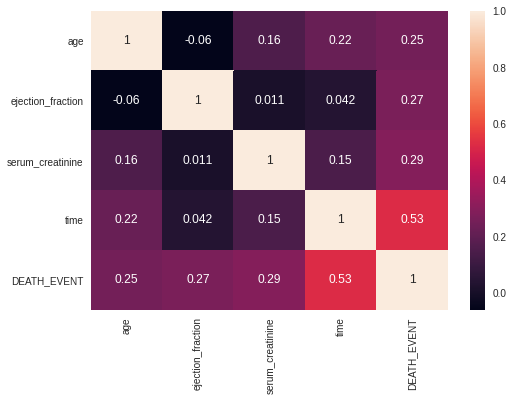

In [ ]:
correlation_mat = heart_failure[['age','ejection_fraction','serum_creatinine','time','DEATH_EVENT']].corr().unstack()

R=heart_failure[['age','ejection_fraction','serum_creatinine','time','DEATH_EVENT']].corr()

print(correlation_mat)
sns.heatmap(R, annot = True)


plt.show()

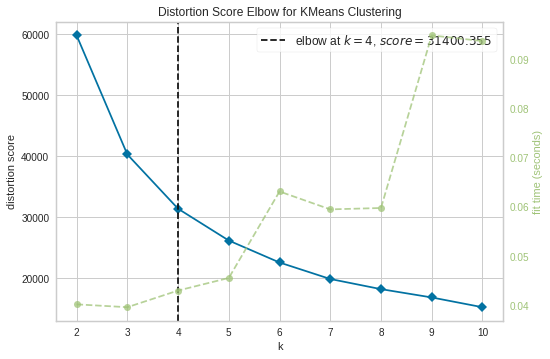

In [ ]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=10)
visualizer.fit(eval2)
visualizer.show()

In [ ]:
result2 = KMeans(n_clusters=5,init='random',max_iter=200).fit(eval2)
result2

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=200, n_clusters=5,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=None,
       tol=0.0001, verbose=0)

In [ ]:
cluster_result2 = list(result2.labels_)
heart_failure2 = heart_failure.assign(Cluster_group = cluster_result2)
heart_failure2.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,Cluster_group
0,75.0,0,582,0,-20,1,265000.00,1.9,-130,1,0,-4,1,3
1,55.0,0,7861,0,-38,0,263358.03,1.1,-136,1,0,-6,1,4
2,65.0,0,146,0,-20,0,162000.00,1.3,-129,1,1,-7,1,3
3,50.0,1,111,0,-20,0,210000.00,1.9,-137,1,0,-7,1,1
4,65.0,1,160,1,-20,0,327000.00,2.7,-116,0,0,-8,1,3


In [ ]:
cluster_2_1 = heart_failure2[heart_failure2['Cluster_group'] == 0]
cluster_2_1.mean()

age                             78.918367
anaemia                          0.387755
creatinine_phosphokinase       622.265306
diabetes                         0.326531
ejection_fraction              -42.775510
high_blood_pressure              0.428571
platelets                   259916.125510
serum_creatinine                 1.628571
serum_sodium                  -136.102041
sex                              0.755102
smoking                          0.326531
time                          -108.530612
DEATH_EVENT                      0.489796
Cluster_group                    0.000000
dtype: float64

In [ ]:
cluster_2_1 = heart_failure2[heart_failure2['Cluster_group'] == 1]
cluster_2_1.mean()

age                             46.619048
anaemia                          0.380952
creatinine_phosphokinase       783.952381
diabetes                         0.444444
ejection_fraction              -31.095238
high_blood_pressure              0.349206
platelets                   275583.970635
serum_creatinine                 1.114921
serum_sodium                  -136.714286
sex                              0.650794
smoking                          0.317460
time                          -134.079365
DEATH_EVENT                      0.301587
Cluster_group                    1.000000
dtype: float64

In [ ]:
cluster_2_1 = heart_failure2[heart_failure2['Cluster_group'] == 2]
cluster_2_1.mean()

age                             58.021739
anaemia                          0.478261
creatinine_phosphokinase       441.478261
diabetes                         0.413043
ejection_fraction              -58.347826
high_blood_pressure              0.369565
platelets                   267111.916957
serum_creatinine                 1.353043
serum_sodium                  -138.000000
sex                              0.500000
smoking                          0.282609
time                          -120.869565
DEATH_EVENT                      0.195652
Cluster_group                    2.000000
dtype: float64

In [ ]:
cluster_2_1 = heart_failure2[heart_failure2['Cluster_group'] == 3]
cluster_2_1.mean()

age                             65.979803
anaemia                          0.484848
creatinine_phosphokinase       386.545455
diabetes                         0.393939
ejection_fraction              -26.242424
high_blood_pressure              0.363636
platelets                   255748.971515
serum_creatinine                 1.602424
serum_sodium                  -135.803030
sex                              0.696970
smoking                          0.378788
time                          -117.075758
DEATH_EVENT                      0.545455
Cluster_group                    3.000000
dtype: float64

In [ ]:
cluster_2_1 = heart_failure2[heart_failure2['Cluster_group'] == 4]
cluster_2_1.mean()

age                             58.155560
anaemia                          0.426667
creatinine_phosphokinase       643.600000
diabetes                         0.480000
ejection_fraction              -38.880000
high_blood_pressure              0.280000
platelets                   259730.535333
serum_creatinine                 1.316400
serum_sodium                  -136.773333
sex                              0.626667
smoking                          0.293333
time                          -158.613333
DEATH_EVENT                      0.106667
Cluster_group                    4.000000
dtype: float64